# <div align="center"> Lenet可视化 </div>

In [45]:
%reload_ext autoreload
%reload_ext tensorboard
%autoreload 2
%matplotlib inline

## Metrics

### 过程类

1. [x] 训练过程中的输入到模型的图片(增强变换之后)
2. [x] loss & loss_avg: training loss, Validation loss
3. [x] lr
4. [x] weight, bias and grad histogram


### 结果类

1. [x] accuracy & accuracy_topX
2. [x] confusion matrix
3. [x] model graph (tensorboard)
4. [ ] 展示分错次数多的分类
5. [ ] psnr & ssim
6. [x] 精确度, 召回率, F1, 
7. [ ] ROC曲线, AUC, 特异性


### 性能类

1. [x] cpu/gpu内存 利用率
2. [x] 训练速度

In [46]:
import os
import shutil
import time
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST 

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

import signal
from tensorboard import notebook
from tensorboard import manager

from k12libs.utils.nb_easy import K12AI_HOST_ADDR, K12AI_NBDATA_ROOT
from k12libs.utils.nb_easy import k12ai_set_notebook
from k12libs.utils.nb_easy import k12ai_start_tensorboard

In [47]:
k12ai_set_notebook(cellw=100)

In [48]:
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array((0.1307,))
    std = np.array((0.3081,))
    print(img.shape, mean.shape, std.shape)
    inp = std * img + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # update

In [49]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

trainset = MNIST(root=f'{K12AI_NBDATA_ROOT}/datasets', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

valset = MNIST(root=f'{K12AI_NBDATA_ROOT}/datasets', train=False, download=True, transform=transform)
valloader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)

In [50]:
trainset.classes, trainset.targets

(['0 - zero',
  '1 - one',
  '2 - two',
  '3 - three',
  '4 - four',
  '5 - five',
  '6 - six',
  '7 - seven',
  '8 - eight',
  '9 - nine'],
 tensor([7, 2, 1,  ..., 4, 5, 6]))

(array([ 980., 1135., 1032., 1010.,  982.,  892.,  958., 1028.,  974.,
        1009.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 1 Patch objects>)

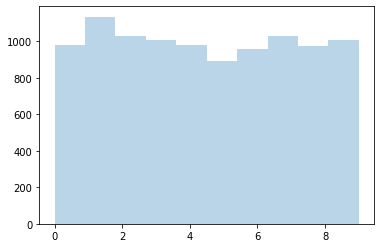

In [51]:
plt.hist(trainset.targets, bins=10, density=False, histtype='stepfilled', alpha=0.3)

batch size =  64  shape =  torch.Size([3, 122, 242]) pic =  torch.Size([1, 28, 28])
(122, 242, 3) (1,) (1,)


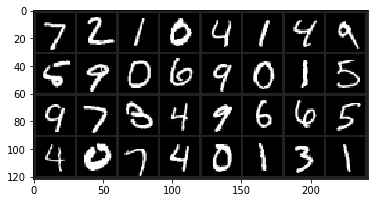

In [74]:
images, labels = next(iter(valloader))
img = torchvision.utils.make_grid(images[:32, :, :, :])
print('batch size = ', len(labels), ' shape = ', img.shape, 'pic = ', images[0].shape)
imshow(img)

In [75]:
print(type(img))

<class 'torch.Tensor'>


In [67]:
img2 = transforms.ToPILImage()(img)
img2.show()

In [72]:
t_out = torch.randn(3,10,10)
img1 = transforms.ToPILImage()(t_out)
imshow(img1)

AttributeError: 'Image' object has no attribute 'numpy'

In [73]:
print(type(img1))

<class 'PIL.Image.Image'>


In [53]:
class Lenet5(torch.nn.Module):
    def __init__(self):
        super(Lenet5, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, (5,5))
        self.conv2 = torch.nn.Conv2d(6, 10, (5,5))
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(160, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc_class = torch.nn.Linear(84, 10)

    def forward(self, X):
        layer1 = torch.tanh(self.conv1(X))
        layer2 = self.pool(layer1)
        layer3 = torch.tanh(self.conv2(layer2))
        layer4 = self.pool(layer3)
        layer4 = layer4.view([layer4.size()[0], 160])
        layer5 = torch.tanh(self.fc1(layer4))
        layer6 = torch.tanh(self.fc2(layer5))
        output_logits = self.fc_class(layer6)
        return output_logits

In [54]:
def run_epoch(model, dataloader, criterion, optimizer=None):
    model = model.cuda()
    model.train()
    accumulated_loss = 0
    correct = 0
    total = 0
    targets_list = []
    predicted_list = []
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        if optimizer:
            optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        if optimizer:
            loss.backward()
            optimizer.step()
        accumulated_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        targets_list.append(targets.cpu())
        predicted_list.append(predicted.cpu())
    return correct, total, round(accumulated_loss, 3), inputs, torch.cat(targets_list), torch.cat(predicted_list)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def heatmap(cm):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(cm.transpose(0, 1), cmap=plt.cm.Blues)
    ax.set_xlabel("True/Actual")
    ax.xaxis.set_label_position('top')
    ax.set_ylabel("Predicted")
    ax.set_xticks(np.arange(cm.shape[0]))
    ax.set_xticklabels(np.arange(cm.shape[0]))
    ax.set_yticks(np.arange(cm.shape[1]))
    ax.set_yticklabels(np.arange(cm.shape[1]))
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(i, j, str(cm[i, j]), ha='center', va='center', color="white" if cm[i, j] > thresh else "black")
    return fig

In [55]:
# true_pos = np.diag(cm)
# false_pos = np.sum(cm, axis=0) - true_pos
# false_neg = np.sum(cm, axis=1) - true_pos
# precision = np.sum(true_pos / (true_pos + false_pos))
# recall = np.sum(true_pos / (true_pos + false_neg)) 

In [56]:
tb_port = 6002
log_dir = f'{K12AI_NBDATA_ROOT}/tmp/mnist/logs_{tb_port}'

if os.path.exists(log_dir):
    shutil.rmtree(log_dir, ignore_errors=True)
writer = SummaryWriter(log_dir=log_dir)

In [57]:
model = Lenet5()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.01, momentum=0.9, weight_decay=5e-4)

writer.add_graph(model, images)

cm = None
epoch_num = 10

pbar = tqdm(range(epoch_num), position=0, leave=True, ncols='50%')
for epoch in pbar:
    train_correct, train_total, train_loss, _, _, _ = run_epoch(model, trainloader, criterion, optimizer)
    train_acc = round(train_correct / train_total, 3)
    
    val_correct, val_total, val_loss, val_img, targets, predicted = run_epoch(model, valloader, criterion, None)
    val_acc = round(val_correct / val_total, 3)
    
    # print('train:', train_correct, train_total, train_loss, train_acc, get_lr(optimizer))
    # print('  val:', val_correct, val_total, val_loss, val_acc)
    
    writer.add_scalar('train/acc', train_acc, epoch)
    writer.add_scalar('train/lr', get_lr(optimizer), epoch)
    writer.add_scalar('val/acc', val_acc, epoch)
    writer.add_scalars('train_val/acc', {'train': train_acc, 'val': val_acc}, epoch)
    writer.add_scalars('train_val/loss', {'train': train_loss, 'val': val_loss}, epoch)
    
    if epoch == 0:
        writer.add_image(f'val/image', torchvision.utils.make_grid(val_img), epoch)
        cm = confusion_matrix(targets, predicted)
        writer.add_figure(f'confusion_matrix/fig-{epoch}', heatmap(cm), close=True)
    if epoch == epoch_num - 1:
        cm = confusion_matrix(targets, predicted)
        writer.add_figure(f'confusion_matrix/fig-{epoch}', heatmap(cm), close=True)
        precision, recall, fscore, support = score(targets, predicted)
        writer.add_text('metrics/precision', str(precision), epoch)
        writer.add_text('metrics/recall', str(recall), epoch)
        writer.add_text('metrics/fscore', str(fscore), epoch)
        writer.add_text('metrics/support', str(support), epoch)
        
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            if module.weight is not None:
                writer.add_histogram('conv/weights/' + name + '.weight', module.weight, epoch)
                writer.add_histogram('conv/gradients/' + name + '.weight.grad', module.weight.grad, epoch)
            if module.bias is not None:
                writer.add_histogram('conv/biases/' + name + '.bias', module.bias, epoch)
                writer.add_histogram('conv/gradients/' + name + '.bias.grad', module.bias.grad, epoch)
        if isinstance(module, torch.nn.Linear):
            if module.weight is not None:
                writer.add_histogram('linear/weights/' + name + '.weight', module.weight, epoch)
                writer.add_histogram('linear/gradients/' + name + '.weight.grad', module.weight.grad, epoch)
            if module.bias is not None:
                writer.add_histogram('linear/biases/' + name + '.bias', module.bias, epoch)
                writer.add_histogram('linear/gradients/' + name + '.bias.grad', module.bias.grad, epoch)
    
# writer.flush()
# writer.close()

In [58]:
cm

array([[ 976,    0,    0,    0,    0,    0,    1,    1,    2,    0],
       [   0, 1134,    1,    0,    0,    0,    0,    0,    0,    0],
       [   1,    5, 1014,    1,    0,    0,    1,    9,    1,    0],
       [   1,    0,    0,  999,    0,    3,    0,    5,    2,    0],
       [   0,    0,    0,    0,  981,    0,    0,    0,    0,    1],
       [   0,    1,    0,    3,    0,  886,    2,    0,    0,    0],
       [   3,    2,    0,    0,    3,    1,  949,    0,    0,    0],
       [   0,    1,    1,    0,    0,    0,    0, 1025,    0,    1],
       [   0,    2,    0,    1,    1,    1,    1,    0,  964,    4],
       [   1,    2,    0,    1,    9,    2,    0,    4,    0,  990]])

In [59]:
# heatmap(cm)
import seaborn as sns

In [63]:
f, ax = plt.subplots(figsize=(12,8))
a = sns.heatmap(cm, annot=True, fmt='d', linewidth=0.5,cmap='Blues', ax=ax, cbar=True)
print(type(a))
f.savefig('/tmp/1.png')
writer.add_figure(f'confusion_matrix/figxx', f, close=True, )

<class 'matplotlib.axes._subplots.AxesSubplot'>


In [64]:
# notebook.list()
# infos = manager.get_all()
# for info in infos:
#     print(info)
#     if info.port == tb_port:
#         !kill {info.pid}
#         
# %tensorboard --host {K12AI_HOST_ADDR} --port {tb_port} --logdir {log_dir} --reload_interval 10
k12ai_start_tensorboard(tb_port, log_dir, reload_interval=10, display=True)

Selecting TensorBoard with logdir /data/nb_data/tmp/mnist/logs_6002 (started 0:00:00 ago; port 6002, pid 3656).


'http://116.85.5.40:6002'